In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from skimage import util

M=256

In [2]:
time=[]
acce=[]
posi=[]

with open('20180531LoadC-01.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        time.append(float(row[0]))
        acce.append(float(row[1]))
        posi.append(float(row[2]))
print(len(posi),len(time),len(acce))

1048558 1048558 1048558


In [3]:
po = []    
vmin = -2.53
dv = (0 - vmin) / 15
lp = len(posi)
for i in range(lp):
    pi=int((posi[i]-vmin) / dv + 0.5)
    if pi > 15:
        pi = po[i-1]
    po.append(pi)
#print('po',po)

pp = []  #list of conditioned encoded position values (int and shifted)
edge = []  # list of index values of encoder signals  
ppmin=100
istart=0
pp.append(po[0]) 
j = 0
count = 0
for i in range(1,lp):
    dp = po[i]-po[i-1]
    if dp != 0:
        if count == 1:
            edge.pop()
            po[i-1]=po[i-2]
            pp[i-1]=pp[i-2]
        dp = po[i]-po[i-1]
        if dp != 0:
            edge.append(i)
            if dp < -5:
                j += 1
                po[i] = 0
            elif dp > 5:
                j -= 1
                po[i] = 15
            elif po[i+1] == po[i-1]:
                po[i]=po[i-1]
        count = 0
    pp.append(po[i]+j*16)
    count += 1
    
ppmin = min(pp)
nedge = len(edge)
#for i in range(1,nedge):
#    print(i,edge[i],po[edge[i]],pp[edge[i]],edge[i]-edge[i-1])
#fig, ax = plt.subplots(figsize=(15,15))
#ax.plot(pp)
#ax.plot(po)
print(len(pp),len(po),len(edge))
print(ppmin,nedge)
#print('pp',pp)


1048558 1048558 7265
-16 7265


In [4]:
for i in range(lp):
    pp[i] -= ppmin
cycle_edge=[]
ncycle = 0
res = 18 * 3.1415926 / 16 / 1000
R = 68.0 / 1000
Nedge=int(2 * R / res) * 2
#ncycle=int((len(edge)-cycle_edge[0])/Nedge)
x0 = 0.019
#xedge = int(Nedge/2) - int(x0 / res + 0.5) - 4
xedge = 1
#print('xedge = ',xedge)

for i in range(nedge):
    if pp[edge[i]] == xedge and pp[edge[i-1]] == (xedge - 1):
        cycle_edge.append(i)
        if i != 0:
            ncycle += 1
        #print(i,edge[i],ncycle)
#print(Nedge, ncycle)

#print(cycle_edge[0],cycle_edge[ncycle-1])
sumacce = 0
j = 0
for i in range(edge[cycle_edge[0]],edge[cycle_edge[ncycle-1]]):
    sumacce += acce[i]
    j += 1
sumacce /= float(j)
for i in range(lp):
    acce[i] -= sumacce
lcycle=int((edge[cycle_edge[ncycle-1]]-edge[cycle_edge[0]])/ncycle)+M
#print("lcycle",lcycle)
#print("cycle_edge",cycle_edge)
#print(len(cycle_edge))
#print('ncycle',ncycle)

rms=np.array([],dtype=float)
for i in range(ncycle-1):
    ndata=0
    rms1=0
    for j in range(edge[cycle_edge[i]],edge[cycle_edge[i+1]]):
        ndata=ndata+1
        rms1=rms1+acce[j]*acce[j]
    rms1=np.sqrt(rms1/ndata)
    rms=np.append(rms,rms1)
#print(rms)


(170, 256)
Shape of `slices`: (256, 170)
256


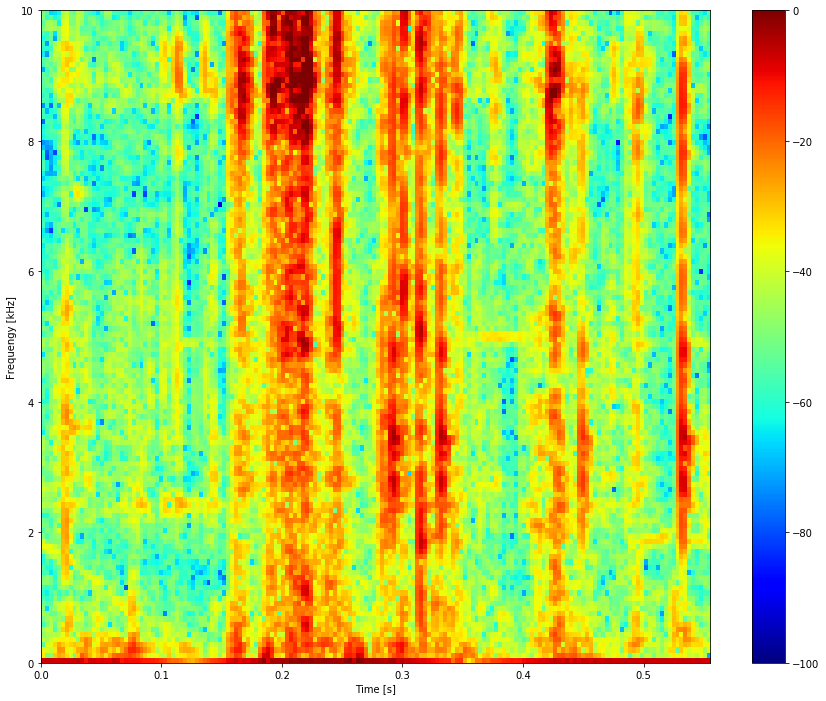

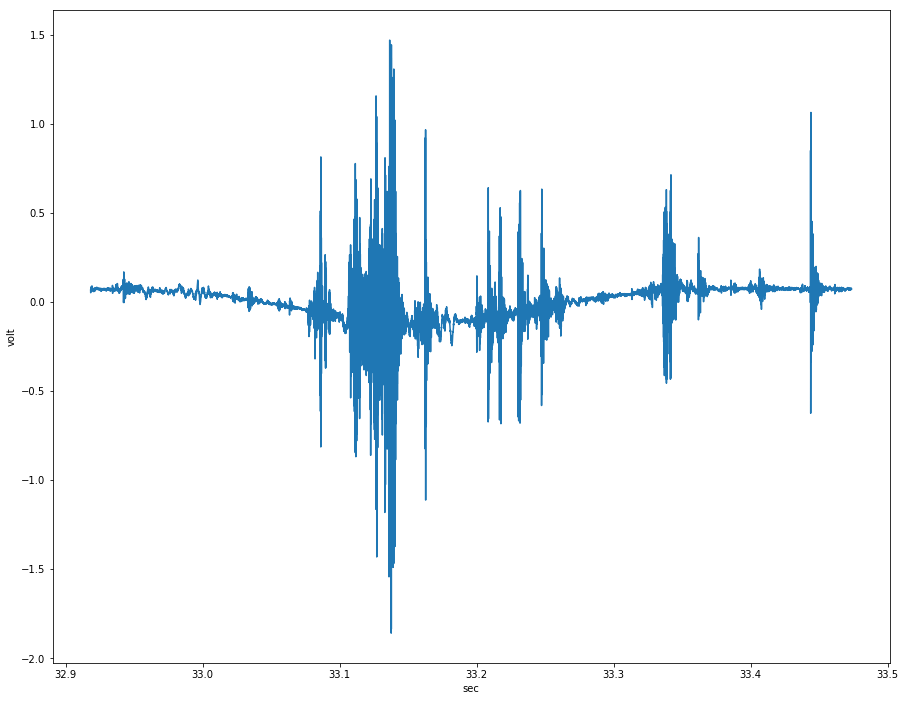

In [5]:
#load_v = np.array([],dtype = int)
#load_v=np.append(load_v,(value))

win = np.hanning(M + 1)[:-1]
st = 64
rate = 20000
icycle = 5
t=time[edge[cycle_edge[icycle]]:edge[cycle_edge[icycle]]+lcycle]
p=acce[edge[cycle_edge[icycle]]:edge[cycle_edge[icycle]]+lcycle]

onecycle_time=np.array([],dtype = float)  # initialize array (extract one cycle acc)
onecycle_acc=np.array([],dtype = float)

onecycle_time=np.append(onecycle_time,t)  #store in an array
onecycle_acc=np.append(onecycle_acc,p)

p1=np.array(p,dtype=float)
N = p1.shape[0]                                                   # p1 (length of one cycle)
L = N / rate                                                      # Resolution (total length )
slices = util.view_as_windows(p1, window_shape=(M,), step = st)
print(slices.shape)
slices = slices * win
slices = slices.T
print('Shape of `slices`:',slices.shape)
spectrum = np.fft.fft(slices, axis = 0)[:M //2 +1:-1]      # changed the length (from (256/2 -1)-126)

#from numpy import empty
#spectrum = empty([126,170])                    #came up with two error of different (shape) and (undefined data)
#spectrum = np.add(spectrum,spectrum1)
#factor = 1.0/(ncycle-1)
#spectrum = np.multiply(spectrum,factor)
S = np.absolute(spectrum)
S_array=np.array([],dtype=float)
S1 = 20*np.log10(S/10)

#trial on single acceleration signal
#spectrum=np.array([])

#print(len(S1))                                                  # its not averaged 
#ax.plot(S1)

#spectrogram
f, ax = plt.subplots(figsize=(15,12)) #spectrum
#print('L',L)
#print('rate',rate)
#a=rate/2/1000
#print('a',a)
im = ax.imshow(S1, origin='lower', cmap=plt.cm.jet,extent=(0, L,0, rate/2/1000 ),vmin=-100,vmax=0)
#print("extent",extent)
ax.axis('tight')
ax.set_ylabel('Frequengy [kHz]')
ax.set_xlabel('Time [s]')
f.colorbar(im, ax=ax)

#print('Shape of spectrum : ',spectrum.shape)

fig, ax = plt.subplots(figsize=(15,12))
ax.plot(t,p)

ax.set_xlabel('sec')
ax.set_ylabel('volt')
print(M)

#ax.plot(S)


In [6]:
for icycle in range(1,ncycle-1):
    p=acce[edge[cycle_edge[icycle]]:edge[cycle_edge[icycle]]+lcycle]
    p1=np.array(p,dtype=float)
    slices = util.view_as_windows(p1, window_shape=(M,), step = st) # acc inside window with step
    slices = slices * win                                           # similarly for 
    slices = slices.T
    spectrum1 = np.fft.fft(slices, axis = 0)[:M // 2 +1:-1]
    #print('Shape of spectrum1 : ',spectrum1.shape)
    spectrum = np.add(spectrum,spectrum1)
factor = 1.0/(ncycle-1)
spectrum = np.multiply(spectrum,factor)
#plt.plot(t,p1)

#from scipy.fftpack import fft
#ff=fft(p1)
#print(len(p1),ff.shape)
#plt.plot(abs(ff))


In [7]:
S = np.absolute(spectrum)
#print(S)
#print(len(S),S.shape)
#fig, ax = plt.subplots(figsize=(15,12))
#ax.plot(S)
#ax.set_xlabel('sec')
#ax.set_ylabel('volt')

In [8]:
Smax = np.max(S)
#print(np.max(S))
#S = 20*np.log10(S/Smax)

S_array=np.array([],dtype=float)
S1 = 20*np.log10(S/10)
#fig, ax = plt.subplots(figsize=(15,12))
print(S1.shape)
#ax.plot(S1)
#S_array=np.append(S_array,S1)
#print("Spectrum",S_array)

(126, 170)


L 0.55545
rate 20000
a 10.0


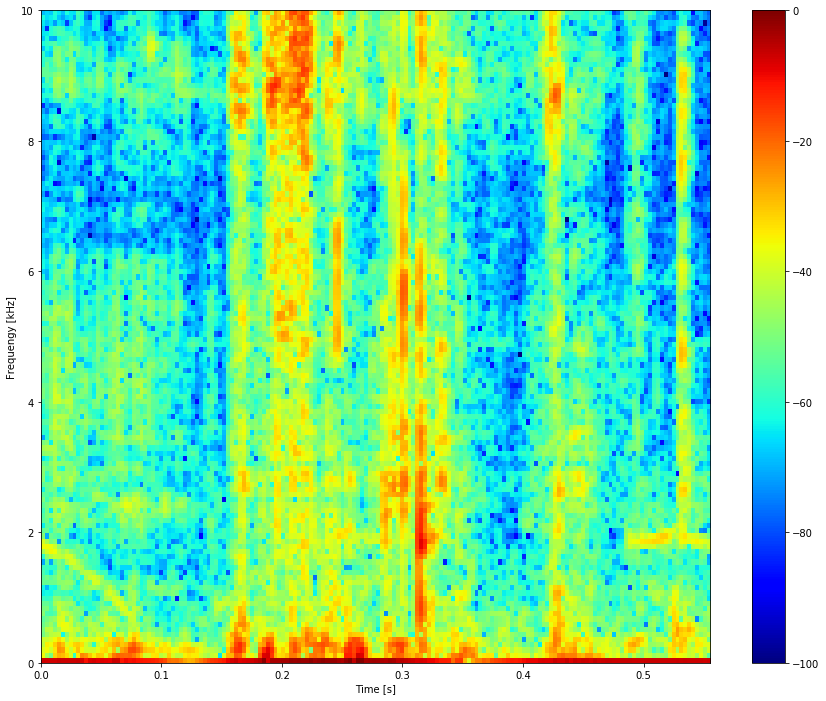

In [9]:
f, ax = plt.subplots(figsize=(15,12)) #spectrum
print('L',L)
print('rate',rate)
a=rate/2/1000
print('a',a)
im = ax.imshow(S1, origin='lower', cmap=plt.cm.jet,extent=(0, L,0, rate/2/1000 ),vmin=-100,vmax=0)
#print("extent",extent)
ax.axis('tight')
ax.set_ylabel('Frequengy [kHz]')
ax.set_xlabel('Time [s]')
f.colorbar(im, ax=ax)

In [10]:
#print(len(edge))
#print(len(cycle_edge))
#print(edge)

10967
gamma =  89.69915984492815 u0 =  0.23798130129514555
nt 10967
10967 10967
11109 N


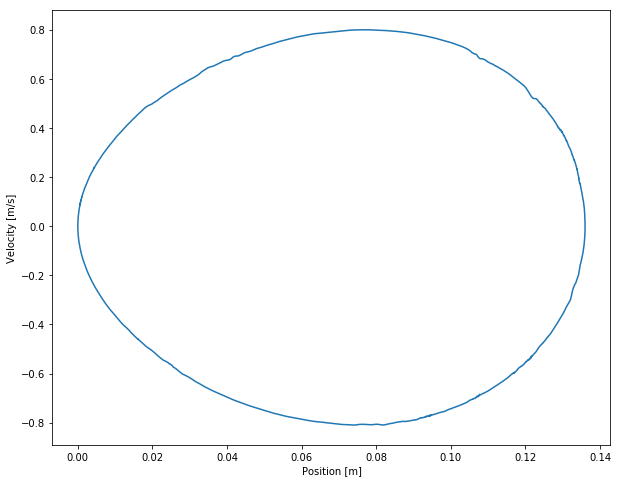

In [11]:
    icycle = 10
#for icycle in range(ncycle-1):
    p = acce[edge[cycle_edge[icycle]]:edge[cycle_edge[icycle+1]]]
    t = time[edge[cycle_edge[icycle]]:edge[cycle_edge[icycle+1]]]
    nt = len(t)
    print(len(p))
#if icycle == 0:
    pmean = 0.0
    for i in range(nt):
        pmean += p[i]
    pmean /= float(nt)
    for i in range(nt):
        p[i] -= pmean
    ub1 = 0.0
    ub2 = 0.0
    xc = []
    xc.append(0)
    for i in range(1,nt):
        ub1 = ub2
        ub2 += (p[i]+p[i-1])/2*(t[i]-t[i-1])
        xc.append(xc[i-1]+(ub1 + ub2)/2*(t[i]-t[i-1]))
    T = t[nt-1] - t[0]
    q = -xc[nt -1] / T
    xp = []
    xp.append(0)
    for i in range(1,nt):
        xp.append(q*(t[i]-t[0])+xc[i])
    xpmin = min(xp)
    xpmax = max(xp)
    gamma = 2*R/(xpmax - xpmin)
    u0 = q * gamma
    print('gamma = ',gamma,'u0 = ',u0)
    print("nt",nt)
#else:
#    gamma =  91.24319715891828
#    u0 =  -0.10755856714674049
    
    x = []
    u = []
    x.append(0)
    u.append(u0)
    for i in range(1,nt):
        u.append(u[i-1] + gamma * (p[i] + p[i-1]) / 2 * (t[i] - t[i-1]))
        x.append(x[i-1] + (u[i] + u[i-1]) / 2 *(t[i] - t[i-1]))
    xmin = min(x)
    xmax = max(x)
    nt1 = nt/2
    for i in range(nt):
        if x[i] == xmax:
            nt1 = i
        x[i] -= xmin

    fig, ax = plt.subplots(figsize=(10,8))
    N1=len(x)
    ax.plot(x,u)
    ax.set_xlabel('Position [m]')
    ax.set_ylabel('Velocity [m/s]')
    print(len(p),len(x))
    print(N,"N")
  

In [12]:
x1=np.array(x,dtype=float)
u1=np.array(u,dtype=float)
print(len(x1))
print(len(u1))

10967
10967


[17.01626346 17.01574931 17.0145056  ... 16.99307484 16.99365079
 16.99363747]
10967
[289.55322201 289.5357245  289.49340083 ... 288.76459239 288.78416725
 288.78371455]


C:\Users\Fluid\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


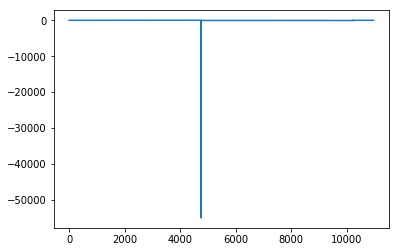

In [19]:
#finding angualr acceleration
#all the dimensions are in m
r=0.068 
l=0.27 
l2=l**2
#di2=di**2
l2=l**2
etta=(r/l)
etta2=etta**2
cos1=np.array([],dtype=float)
sin1=np.array([],dtype=float)
omega=np.array([],dtype=float)
aa=np.array([],dtype=float)

for i in range (len(x1)):
    x=x1[i]+(l-r)
    x2=x**2
    zeta=x/l
    x_r=x/r
    zeta2=zeta**2
    num=(1-etta2-zeta2) 
    deno=2*etta*zeta
    costheta=num/deno
#print(costheta)
    costheta2=costheta**2
    sintheta=(1-costheta2)**0.5
    cos1=np.append(cos1,costheta)
    sin1=np.append(sin1,sintheta)
#calculate omega
    u=u1[i]
    sin=sin1[i]
    sin2=sin**2
    cos=cos1[i]
    apart=r*sin
    bpart=(1-(1/(x_r-1)))
    #num1=-etta*r*sin*cos
    #deno1=(x/l)-etta*cos
    #num2=r*sin
    #omega1=u/(num1/deno1)+num2
    omega1=u/(apart*bpart)
    a_acc=omega1
    omega=np.append(omega,omega1)
    aa=np.append(aa,a_acc)

#print(cos1)
#print(sin1)
plt.plot(omega)
print(omega)
print(len(omega))
print(aa)



In [48]:

print(len(p1)) #add of lcycle
print(len(x))
print(len(p))
print(len(t))

11109
10967
10967
10967


10967
10967
56 74
18
[0.11700459 0.11890104 0.12071712 0.12241499 0.1240546  0.12560931
 0.12707501 0.12844593 0.12971829 0.13089954 0.13196368 0.13290945
 0.13373439 0.13441362 0.13495309 0.13537639 0.13569665 0.13590705]
[30.71086652 44.59378923 26.71442479  7.56143099  4.30165048  4.72800229
  6.19979143 17.56880836 22.06140606 11.10765419  9.63045439 17.89981118
 14.64767022 17.37668352 15.34565462 23.12867592 17.83207473 12.63849247]


Text(0, 0.5, 'Power [a.u.]')

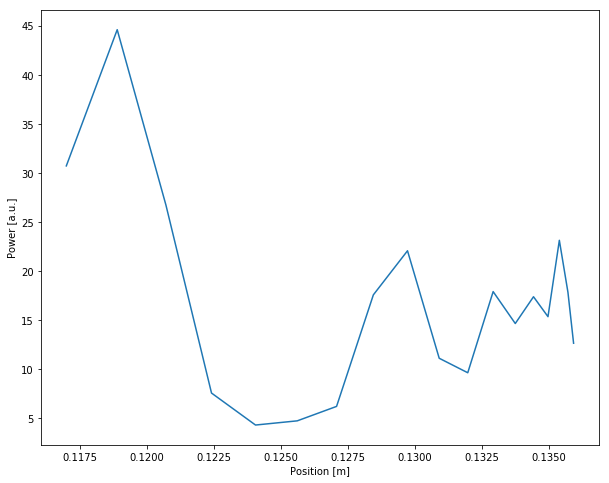

In [49]:
print(len(x))
print(len(p))
start=0
stop=0
dist0=0
for i in range(len(p)):  # N is 10966
    dist=x[i]
    ddist=dist-dist0
    dist0=dist
    if dist >= 0.117 and dist <= 0.136 and ddist > 0:
        if start == 0:
            start = i
        stop=i
        
istart=int(start/st)
istop=int(stop/st)

print(istart,istop)

sum_power=np.empty([istop-istart],dtype=float)
print(len(sum_power))
for j in range(1,13):
    for i in range(len(sum_power)):
        sum_power[i]=sum_power[i]+S[j][i+istart]
xx=np.array([],dtype=float)
for i in range(len(sum_power)):
    xx=np.append(xx,(x[(istart+i)*st]))
print(xx)
print(sum_power)
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(xx,sum_power)
ax.set_xlabel('Position [m]')
ax.set_ylabel('Power [a.u.]')


10967
10967
10969 10967


ValueError: x and y must have same first dimension, but have shapes (10967,) and (10969,)

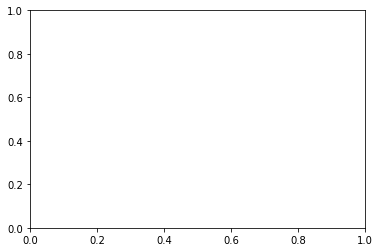

In [34]:
print(len(x))
print(len(p))
win = np.hanning(M + 1)[:-1]
st = 64
rate = 20000
icycle = 0
p=acce[edge[cycle_edge[icycle]]:edge[cycle_edge[icycle+1]]]
posi=x
print(len(p),len(x))     # Do the spectrogram of for position defined accelero data
plt.plot(x,p)
print(len(x))
print(len(p))

[0.06153015 0.06610778 0.0609198  ... 0.07282165 0.06580261 0.06366638]
10966 10966


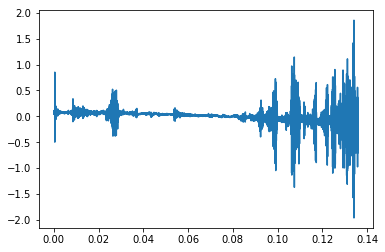

In [44]:
x=np.array(x,dtype=float)
#print(x)
p=np.array(p,dtype=float)
print(p)
print(len(x),len(p))
plt.plot(x,p)

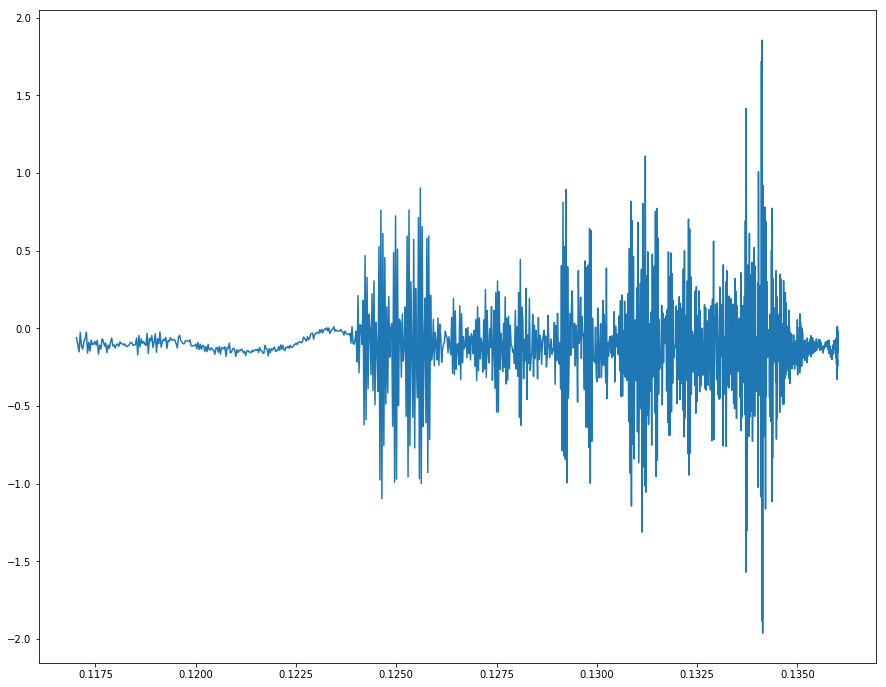

In [46]:
#for 1 cycle stft (within forging displacement after 19mm)

from scipy.fftpack import fft
forging_as=np.array([],dtype=float) #acceleration
forging_ps=np.array([],dtype=float) #position
#xa=dict(zip(x,p))
dist0=0
for i in range(len(x)):
    dis=x[i]
    acc=p[i]
    ddist=dis-dist0             #decreasing values get neglected and increasing gets stored
    dist0=dis      
    if dis>=0.117 and dis<=0.136 and ddist>0:
        forging_ps=np.append(forging_ps,dis)
        forging_as=np.append(forging_as,acc)  
fig, ax = plt.subplots(figsize=(15,12))
ax.plot(forging_ps,forging_as)

#plt.plot(forging_as)        


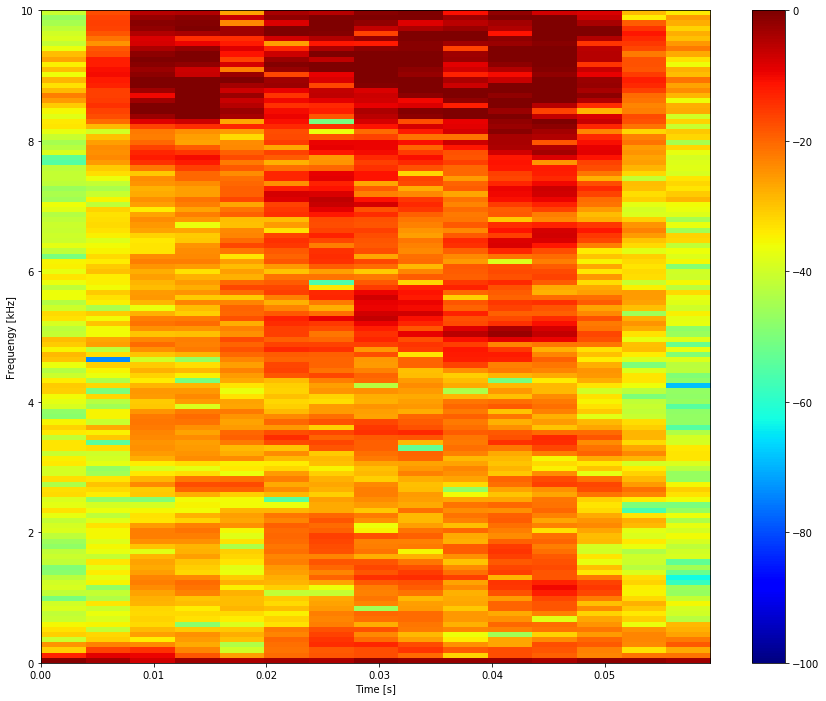

In [47]:
N = forging_as.shape[0]                                                   # p1 (length of one cycle)
L = N / rate         
slicesf = util.view_as_windows(forging_as, window_shape=(M,), step = st) # acc inside window with step
slicesf = slicesf * win                                                   # similarly for 
slicesf = slicesf.T
spectrum1f = np.fft.fft(slicesf, axis = 0)[:M // 2 +1:-1]

#print('Shape of spectrum1 : ',spectrum1.shape)                          (what are these?)
#spectrum = np.add(spectrum,spectrum1)
#factor = 1.0/(ncycle-1)
#spectrum = np.multiply(spectrum,factor)

Sf = np.absolute(spectrum1f)      # sf is kept to remove the redundancy with the above name
S1f = 20*np.log10(Sf/10)

f, ax = plt.subplots(figsize=(15,12)) #spectrum
im = ax.imshow(S1f, origin='lower', cmap=plt.cm.jet,extent=(0, L,0, rate/2/1000 ),vmin=-100,vmax=0)
#print("extent",extent)
ax.axis('tight')
ax.set_ylabel('Frequengy [kHz]')
ax.set_xlabel('Time [s]')
f.colorbar(im, ax=ax)



#plt.plot(t,p1)
#fft_s=fft(forging_as)

#ax.plot(abs(fft_s))
#ax.set_xlabel('Position [m]')
#ax.set_ylabel('Velocity [m/s]')


In [48]:
p=acce[edge[cycle_edge[icycle]]:edge[cycle_edge[icycle]]+lcycle]
print(len(p))
print(len(x))

11105
10966


In [ ]:
#PROGRAM FOR RMS CALCULTAION OF THE FORGING AREA
rms=np.array([],dtype=float)
print(icycle)
print(ncycle)
#print(ndata)
ndata=0
rms1=0
for i in range (ncycle-1):
    print("ncycle",i)
    dist0=0
    for j in range (len(p)):
        dist=x[j]
        acc=p[j]
        ddist=dist-dist0
        dist0=dist
        if dist>=0.117 and dist<=0.136 and ddist>0:
                ndata=ndata+1
                rms1=rms1+acc[i]*acc[i]
rms1=np.sqrt(rms1/ndata)
rms=np.append(rms,rms1)
print(rms)
plt.plot(rms)

In [ ]:
rms=np.array([],dtype=float)
for i in range (icycle-1):
    ndata=1
    rms1=0
    for j in range (len(x)):
        dis=x[j]
        acc=p[j]
        if dis>=0.117 and dis<=0.136:
            rms1=rms1+acc*acc
    rms1=np.sqrt(rms1/ndata)
    rms=np.append(rms,rms1)
print(rms)

In [ ]:
rms=np.array([],dtype=float)
for i in range(icycle-1):
    ndata=1
    rms1=0
    xa[i]=dict(zip(x,p))
    for j in range(edge[cycle_edge[i]],edge[cycle_edge[i+1]]):
        for dis,acc in xa[i].items():
            if dis>=0.117 and dis<=0.136:
                rms1=rms1+acc*acc
    rms1=np.sqrt(rms1/ndata)
    rms=np.append(rms,rms1)
print(rms)

In [50]:
#for ncycles the STFT with the forging accelero data along with RMS over the range.
for icycle in range(1,ncycle-1):
    p=acce[edge[cycle_edge[icycle]]:edge[cycle_edge[icycle]]+lcycle]  # shape of p= 10966 (addition of lcycle)
    p1=np.array([],dtype=float)
    #xp[icycle]=dict(zip(x,p))
    for j in range(len(p)):
        dis=x[i]
        acc=p[i]
        ddist=dis-dist0
        dist0=dis
        if dis>=0.117 and dis<=0.136 and ddist>0:
            p1=np.append(p1,p)
    slices = util.view_as_windows(p1, window_shape=(M,), step = st) # acc inside window with step
    slices = slices * win                                           # similarly for 
    slices = slices.T
    spectrum1 = np.fft.fft(slices, axis = 0)[:M // 2 +1:-1]
    #print('Shape of spectrum1 : ',spectrum1.shape)
    spectrum = np.add(spectrum,spectrum1)
factor = 1.0/(ncycle-1)
spectrum1f = np.multiply(spectrum,factor)


Sf = np.absolute(spectrum1f)      # sf is kept to remove the redundancy with the above name
S1f = 20*np.log10(Sf/10)

f, ax = plt.subplots(figsize=(15,12)) #spectrum
im = ax.imshow(S1f, origin='lower', cmap=plt.cm.jet,extent=(0, L,0, rate/2/1000 ),vmin=-100,vmax=0)
#print("extent",extent)
ax.axis('tight')
ax.set_ylabel('Frequengy [kHz]')
ax.set_xlabel('Time [s]')
f.colorbar(im, ax=ax)

print(p1)

ValueError: `window_shape` is too large

In [16]:
#for ncycles the STFT with the forging accelero data along with RMS over the range.
for icycle in range(1,ncycle-1):
    p=acce[edge[cycle_edge[icycle]]:edge[cycle_edge[icycle]]+lcycle]  # shape of p= 10966 (addition of lcycle)
    p1=np.array([],dtype=float)
    xp[icycle]=dict(zip(x,p))
    for x,p in xp[icycle].items():
        if x>=0.117 and x<=0.136:
            p1=np.append(p1,p)
print(p1)


TypeError: zip argument #1 must support iteration

In [ ]:
# main idea
for icycle in range(1,ncycle-1):
    p=acce[edge[cycle_edge[icycle]]:edge[cycle_edge[icycle]]+lcycle]
    p1=np.array(p,dtype=float)
    p2=np.array(p2,dtype=float)
    xp=dict(zip(x,p1))
    for x,p in xp.items():
        if x>=0.117 and dis<=0.136:
            p2=np.append(p2,p)
    slices = util.view_as_windows(p2, window_shape=(M,), step = st) # acc inside window with step
    slices = slices * win                                           # similarly for 
    slices = slices.T
    spectrum1 = np.fft.fft(slices, axis = 0)[:M // 2 +1:-1]
    #print('Shape of spectrum1 : ',spectrum1.shape)
    spectrum = np.add(spectrum,spectrum1)
factor = 1.0/(ncycle-1)
spectrum = np.multiply(spectrum,factor)
#plt.plot(t,p1)

from scipy.fftpack import fft
ff=fft(p1)
print(len(p1),ff.shape)
plt.plot(abs(ff))


In [2]:
import numpy as np
rms=np.array([],dtype=float)
for i in range(edge[cycle_edge[ncycle]],edge[cycle_edge[ncycle-1]]):
    ndata=0
    rms1=0
    for dis,acc in xa[i].items():
        ndata=ndata+1
        rms1=rms1+acce[i]*acce[i]
    rms1=np.sqrt(rms1/ndata)
    rms=np.append(rms,rms1)
print(rms)

NameError: name 'edge' is not defined

In [93]:
rms=np.array([],dtype=float)
for i in range(icycle-1):
    ndata=1
    rms1=0
    xa[i]=dict(zip(x,p))
    for j in range(edge[cycle_edge[i]],edge[cycle_edge[i+1]]):
        for dis,acc in xa[i].items():
            if dis>=0.117 and dis<=0.136:
                rms1=rms1+acc*acc
    rms1=np.sqrt(rms1/ndata)
    rms=np.append(rms,rms1)
print(rms)

In [ ]:
rms=np.array([],dtype=float)
for i in range(ncycle-1):
    ndata=0
    rms1=0
    for j in range(edge[cycle_edge[i]],edge[cycle_edge[i+1]]):
        ndata=ndata+1
        rms1=rms1+acce[j]*acce[j]
    rms1=np.sqrt(rms1/ndata)
    rms=np.append(rms,rms1)
print(rms)

{0: 3, 1: 7, 2: 2, 3: 3, 4: 4, 5: 6, 6: 7, 7: 7, 8: 7, 9: 9, 10: 8}
[2, 3, 4, 5, 6, 7, 8, 9]
[2, 3, 4, 6, 7, 7, 7, 9]


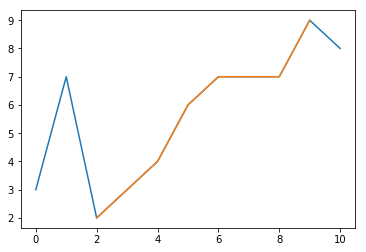

In [29]:
a1=[]
b1=[]
a=[0,1,2,3,4,5,6,7,8,9,10]
b=[3,7,2,3,4,6,7,7,7,9,8,]

ab=dict(zip(a,b))
for k,v in ab.items():
    if k>=2 and k<=9:
        a1.append(k)
        b1.append(v)        
print(ab)
print(a1)
print(b1)
plt.plot(a,b)
plt.plot(a1,b1)



   

Text(0, 0.5, 'Specific Kinetic Energy [J/kg]')

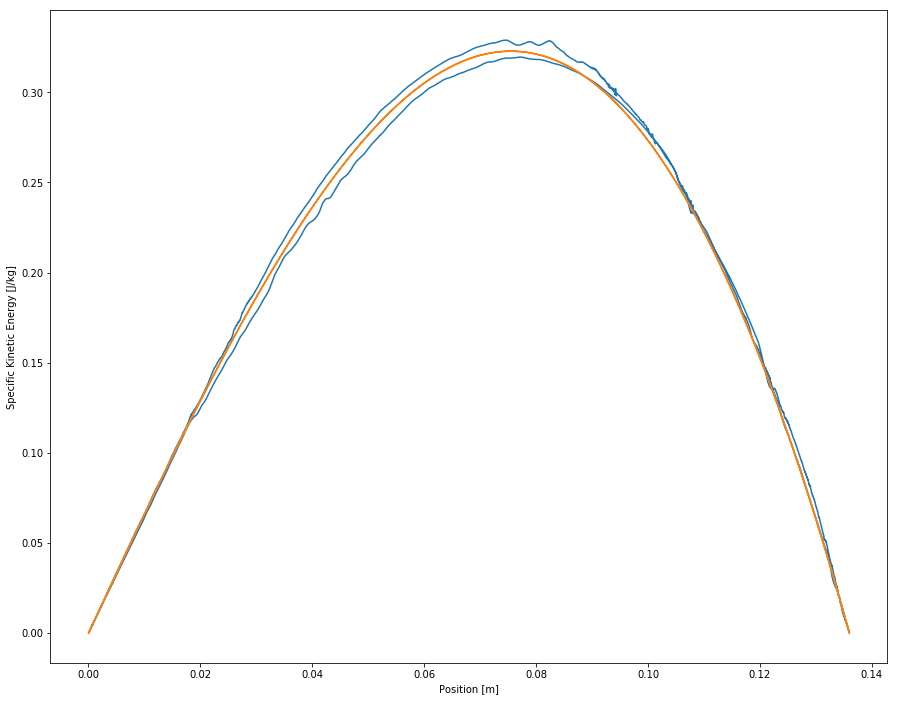

In [15]:

ke1 = []
for i in range(nt):
    ke1.append(u[i]*u[i]/2)

L = 270.0 / 1000
eta = R / L
eta2 = eta * eta
omega = 2 * np.pi / T
ke2 = []
for i in range(nt):
    xol = (L - R + x[i]) / L
    ct = -(eta * eta + xol * xol -1) / (2 * eta *xol)
    st2 = 1.0 - ct * ct
    if np.absolute(ct) > 1:
        #print('ct = ',ct,'st2 = ',st2)
        ct = 1.0
        st2 = 0.0
    st = np.sqrt(st2)
    u1 = R * omega * (st - eta * st * ct / np.sqrt(1.0 - eta2*st2))
    ke2.append(u1 * u1 / 2)

fig, ax = plt.subplots(figsize=(15,12))
#print('ke2',ke2)
color1 = 'tab:red'
color2 = 'tab:blue'
ax.plot(x,ke1,x,ke2)
ax.set_xlabel('Position [m]')
ax.set_ylabel('Specific Kinetic Energy [J/kg]')

(-0.01, 0.01)

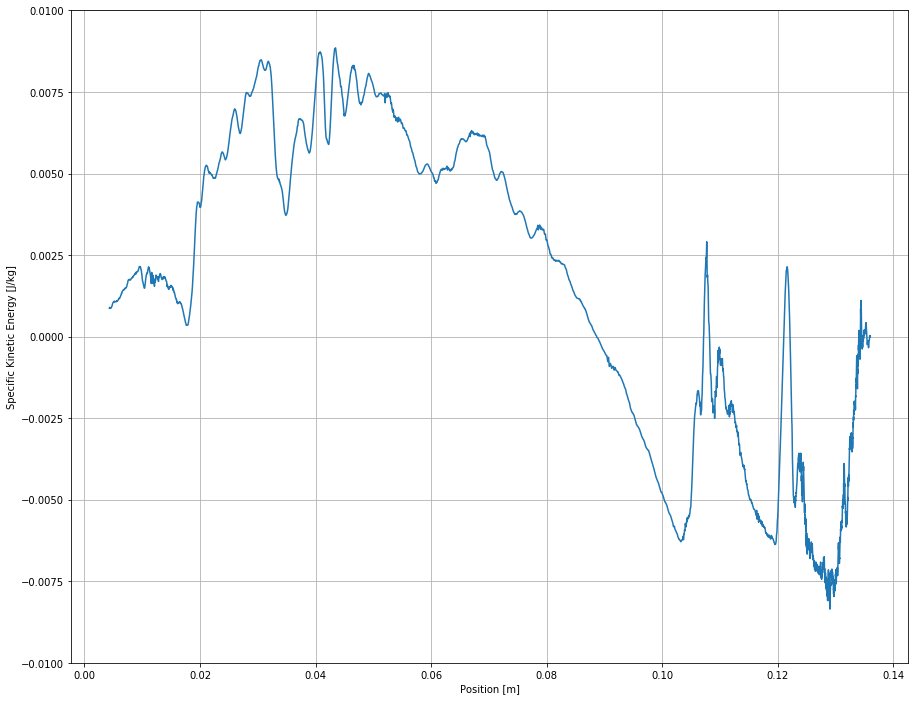

In [14]:
dke = []
x2 = []
for i in range(nt1):
    dke.append(ke2[i]-ke1[i])
    x2.append(x[i])
fig, ax = plt.subplots(figsize=(15,12))
ax.plot(x2,dke)
ax.set_xlabel('Position [m]')
ax.set_ylabel('Specific Kinetic Energy [J/kg]')
plt.grid(True)
plt.ylim(-0.01,0.01)